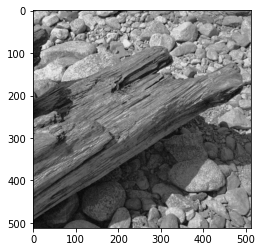

In [5]:
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
data = scipy.io.loadmat('IMAGES_RAW.mat')
images = data['IMAGESr']
#Show the first image.
plt.imshow(images[:,:,0], cmap='gray')
# Function to sample image patches from the large images.

def sample_random_square_patches(image, num, width):
    patches = np.zeros([width,width,num])
    for k in range(num):
        i, j = random.sample(range(image.shape[0]-width),2)
        patches[:,:,k] = image[i:i+width,j:j+width] 
    return patches

# Initialize and show codebook

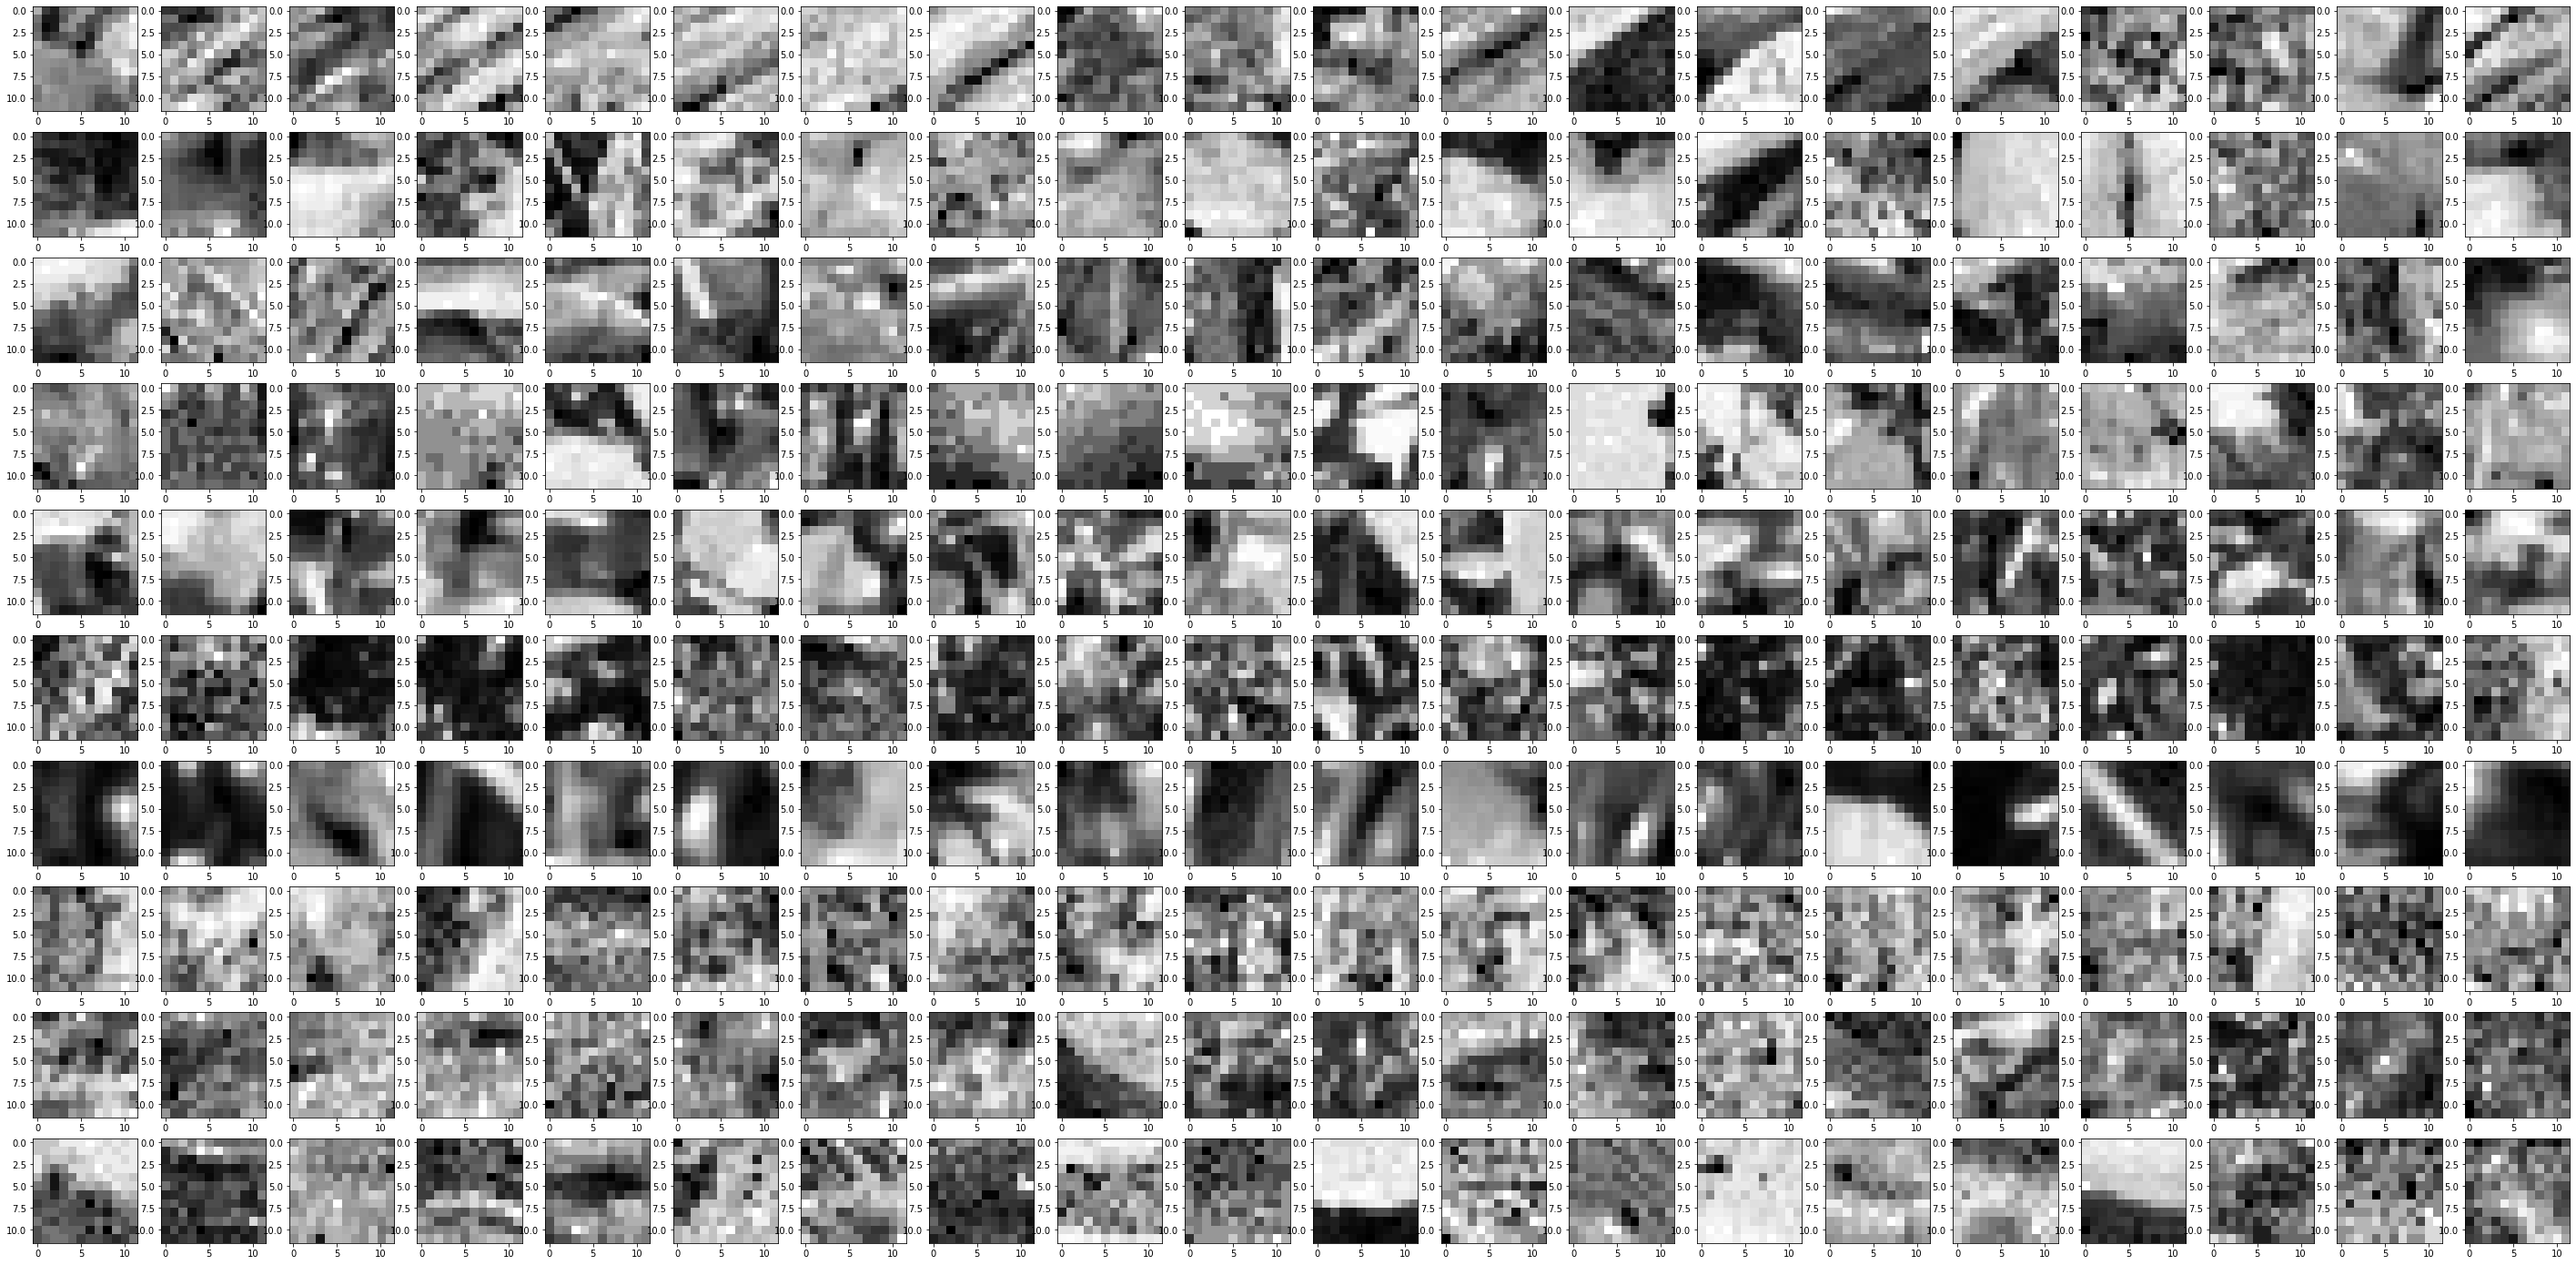

In [19]:
from sklearn import linear_model, preprocessing
import random, copy

width = 12
#select n patches each from given indices of random images
#input: # patches per img, indexes to select from
def n_patches_per_img(n, m_idx, arr):
    for i, j in enumerate(m_idx):
        cur_patches = sample_random_square_patches(
            images[:,:,j], n, width)
        arr[:,:,n*i:n*i+n] = cur_patches
        
#print codebook in array of 20 x 10
def print_codebook(v):
    fig = plt.figure(figsize=(50, 25))
    for i in range(200):
        sub = fig.add_subplot(10, 20, i + 1)
        sub.imshow(v[:,:,i], cmap='gray')

#fix V, initialize codebook of 20 samples from each image
v = np.zeros([width, width, 200])
n_patches_per_img(20, list(range(10)), v)
#reshapes into dxL array, features are columns
v_reshape = np.reshape(v, (144, 200))
#normalize columns, calculus Frobeus norm
v_norm = preprocessing.normalize(v_reshape, axis=0) 

#show initial randomly sampled codebook
print_codebook(v_norm.reshape(12, 12, 200))

We want to find the gradient of the Frobeus norm. At each step, we comput this value and store it into the list of gradients; then we compute the new codebook, $V^{new}$ using stochastic gradient descent.
$$C(V) = ||X-VA||^2_F$$
$$\nabla_V C(V) = -2(X-VA)A^t$$
$$V^{new} = V - \eta \nabla_V C(V)$$

# Iterate over steps in SGD 

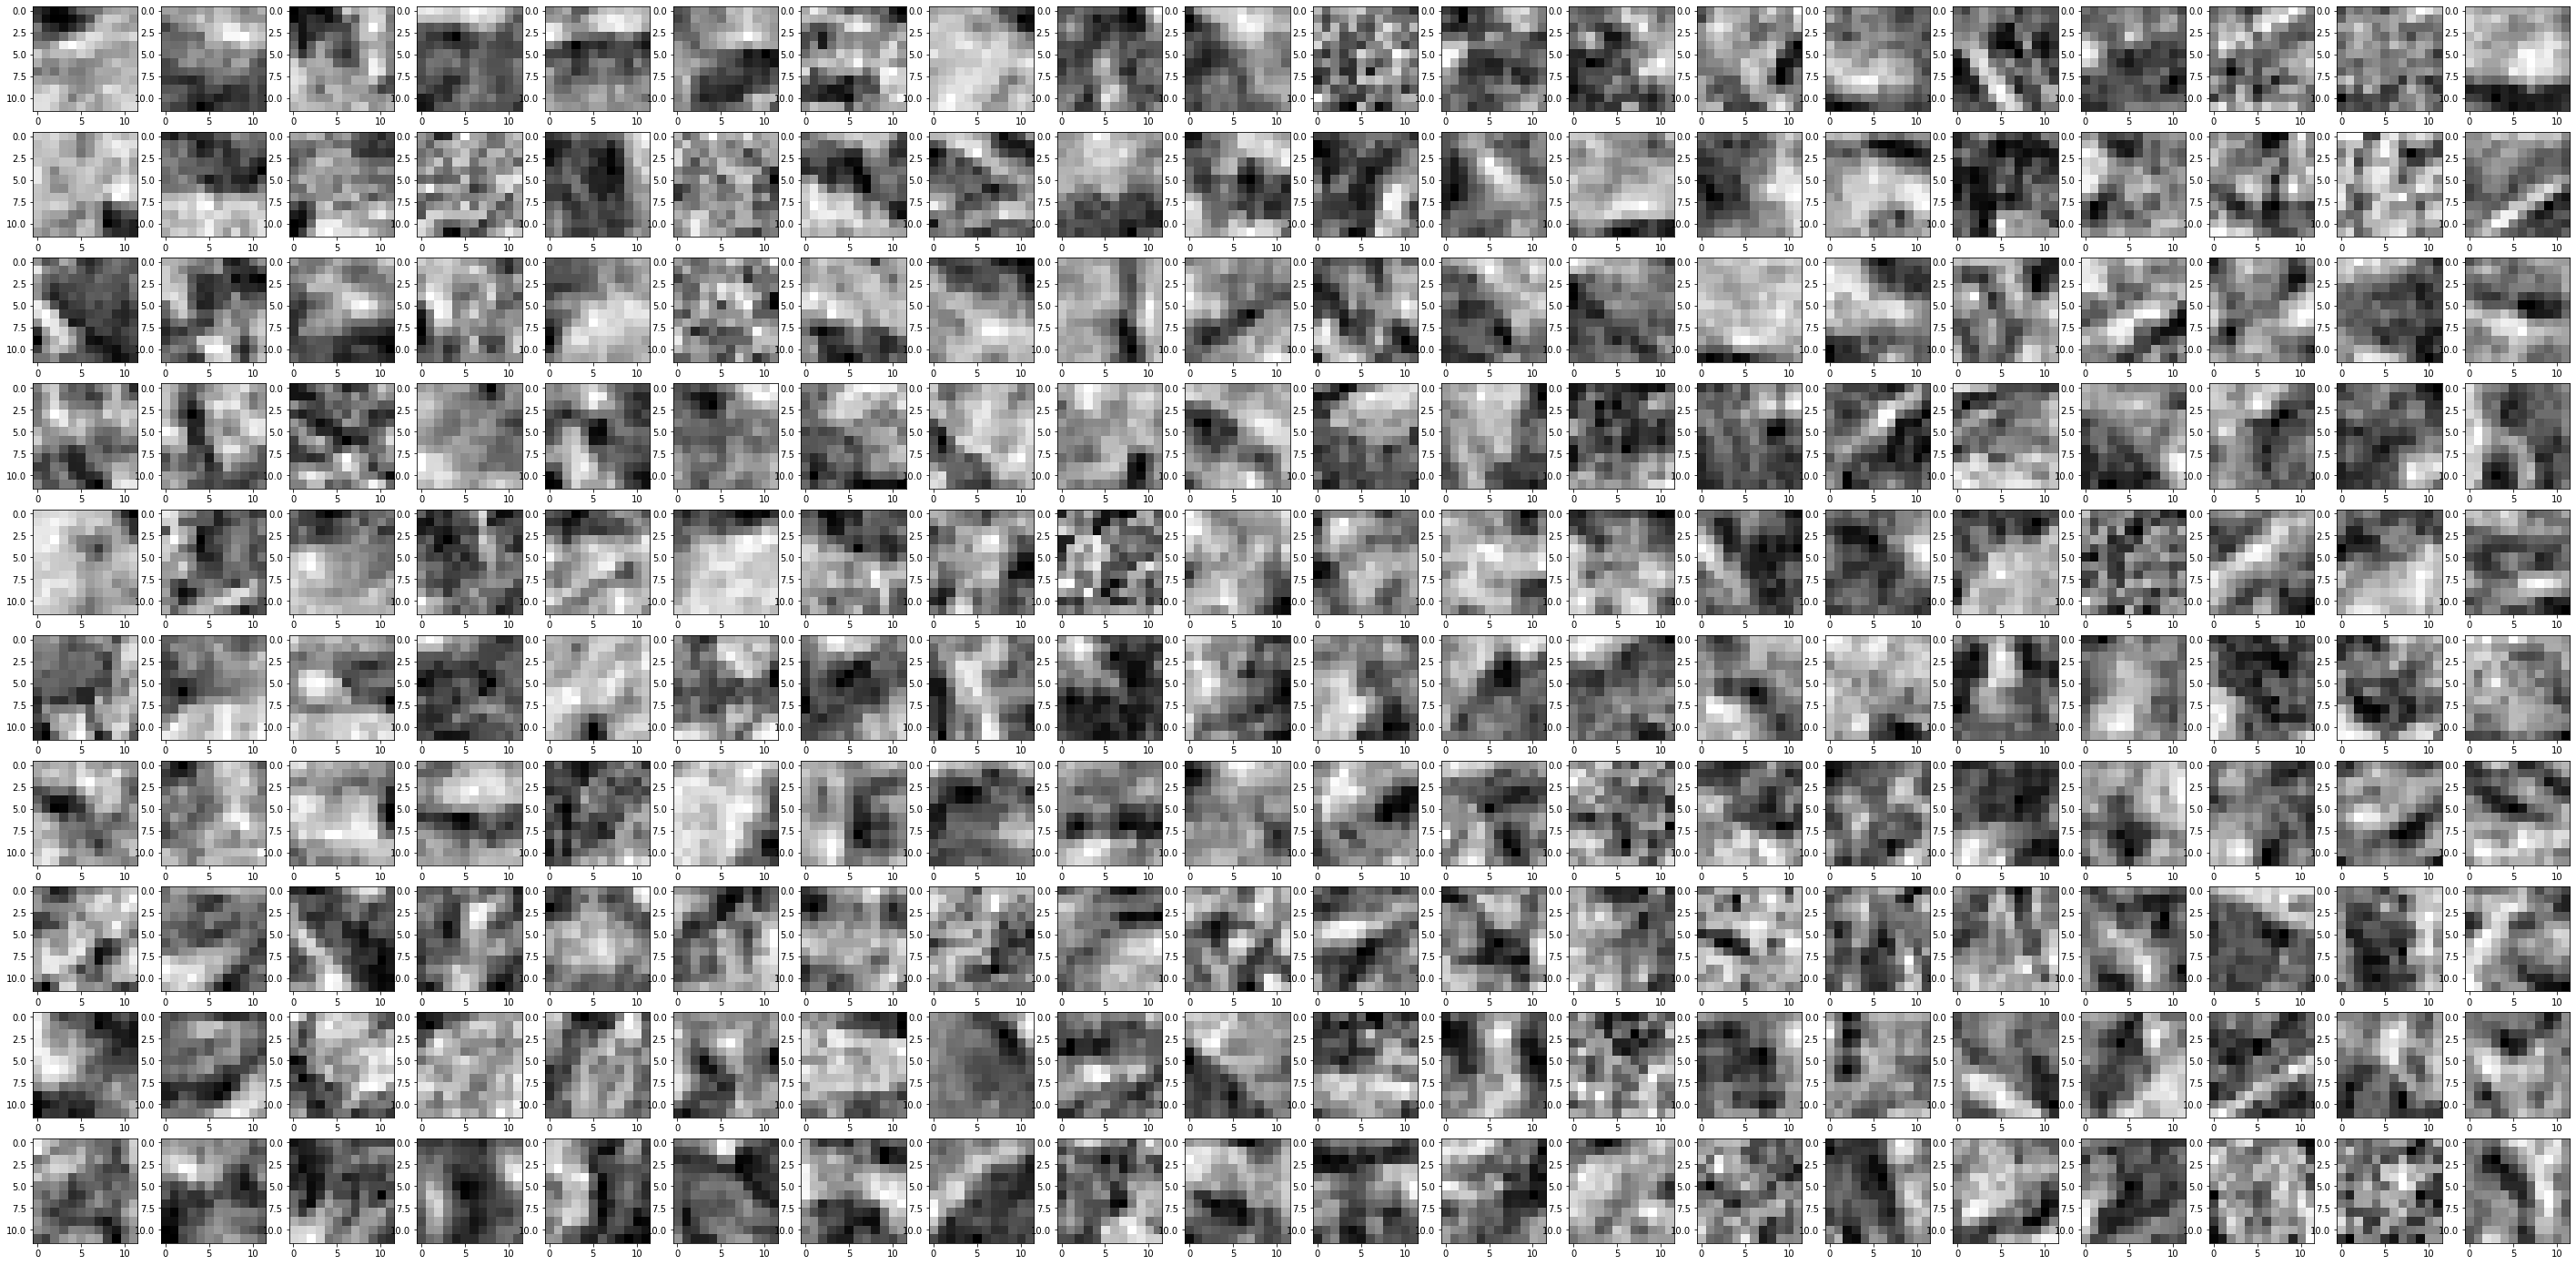

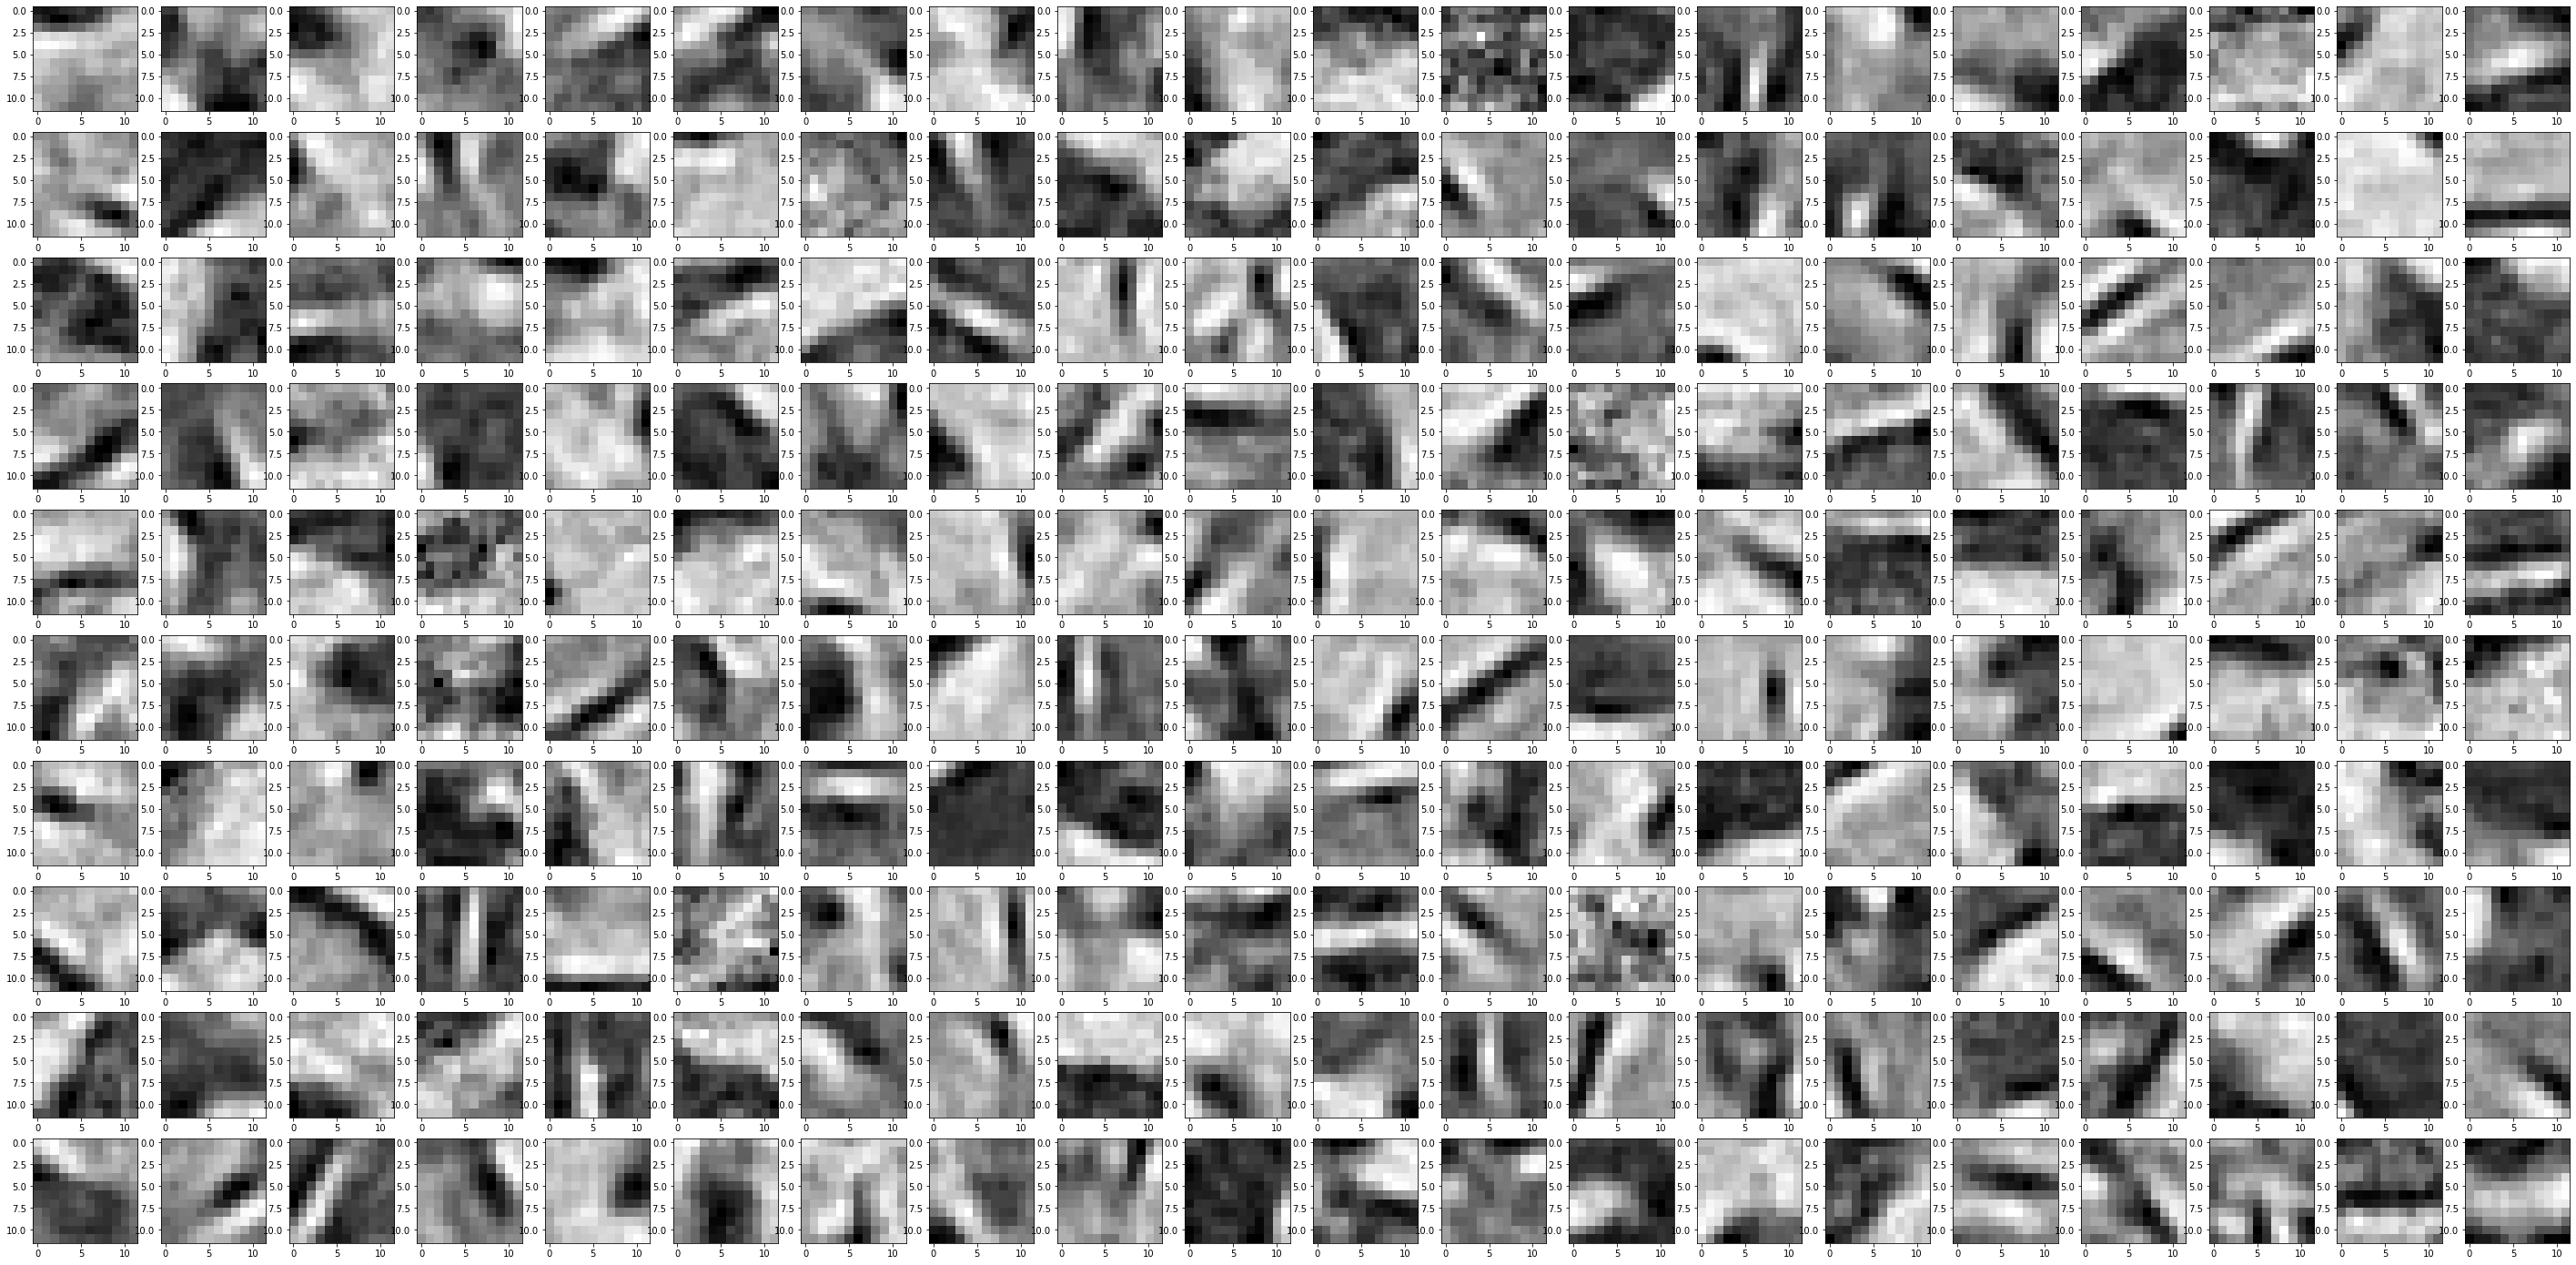

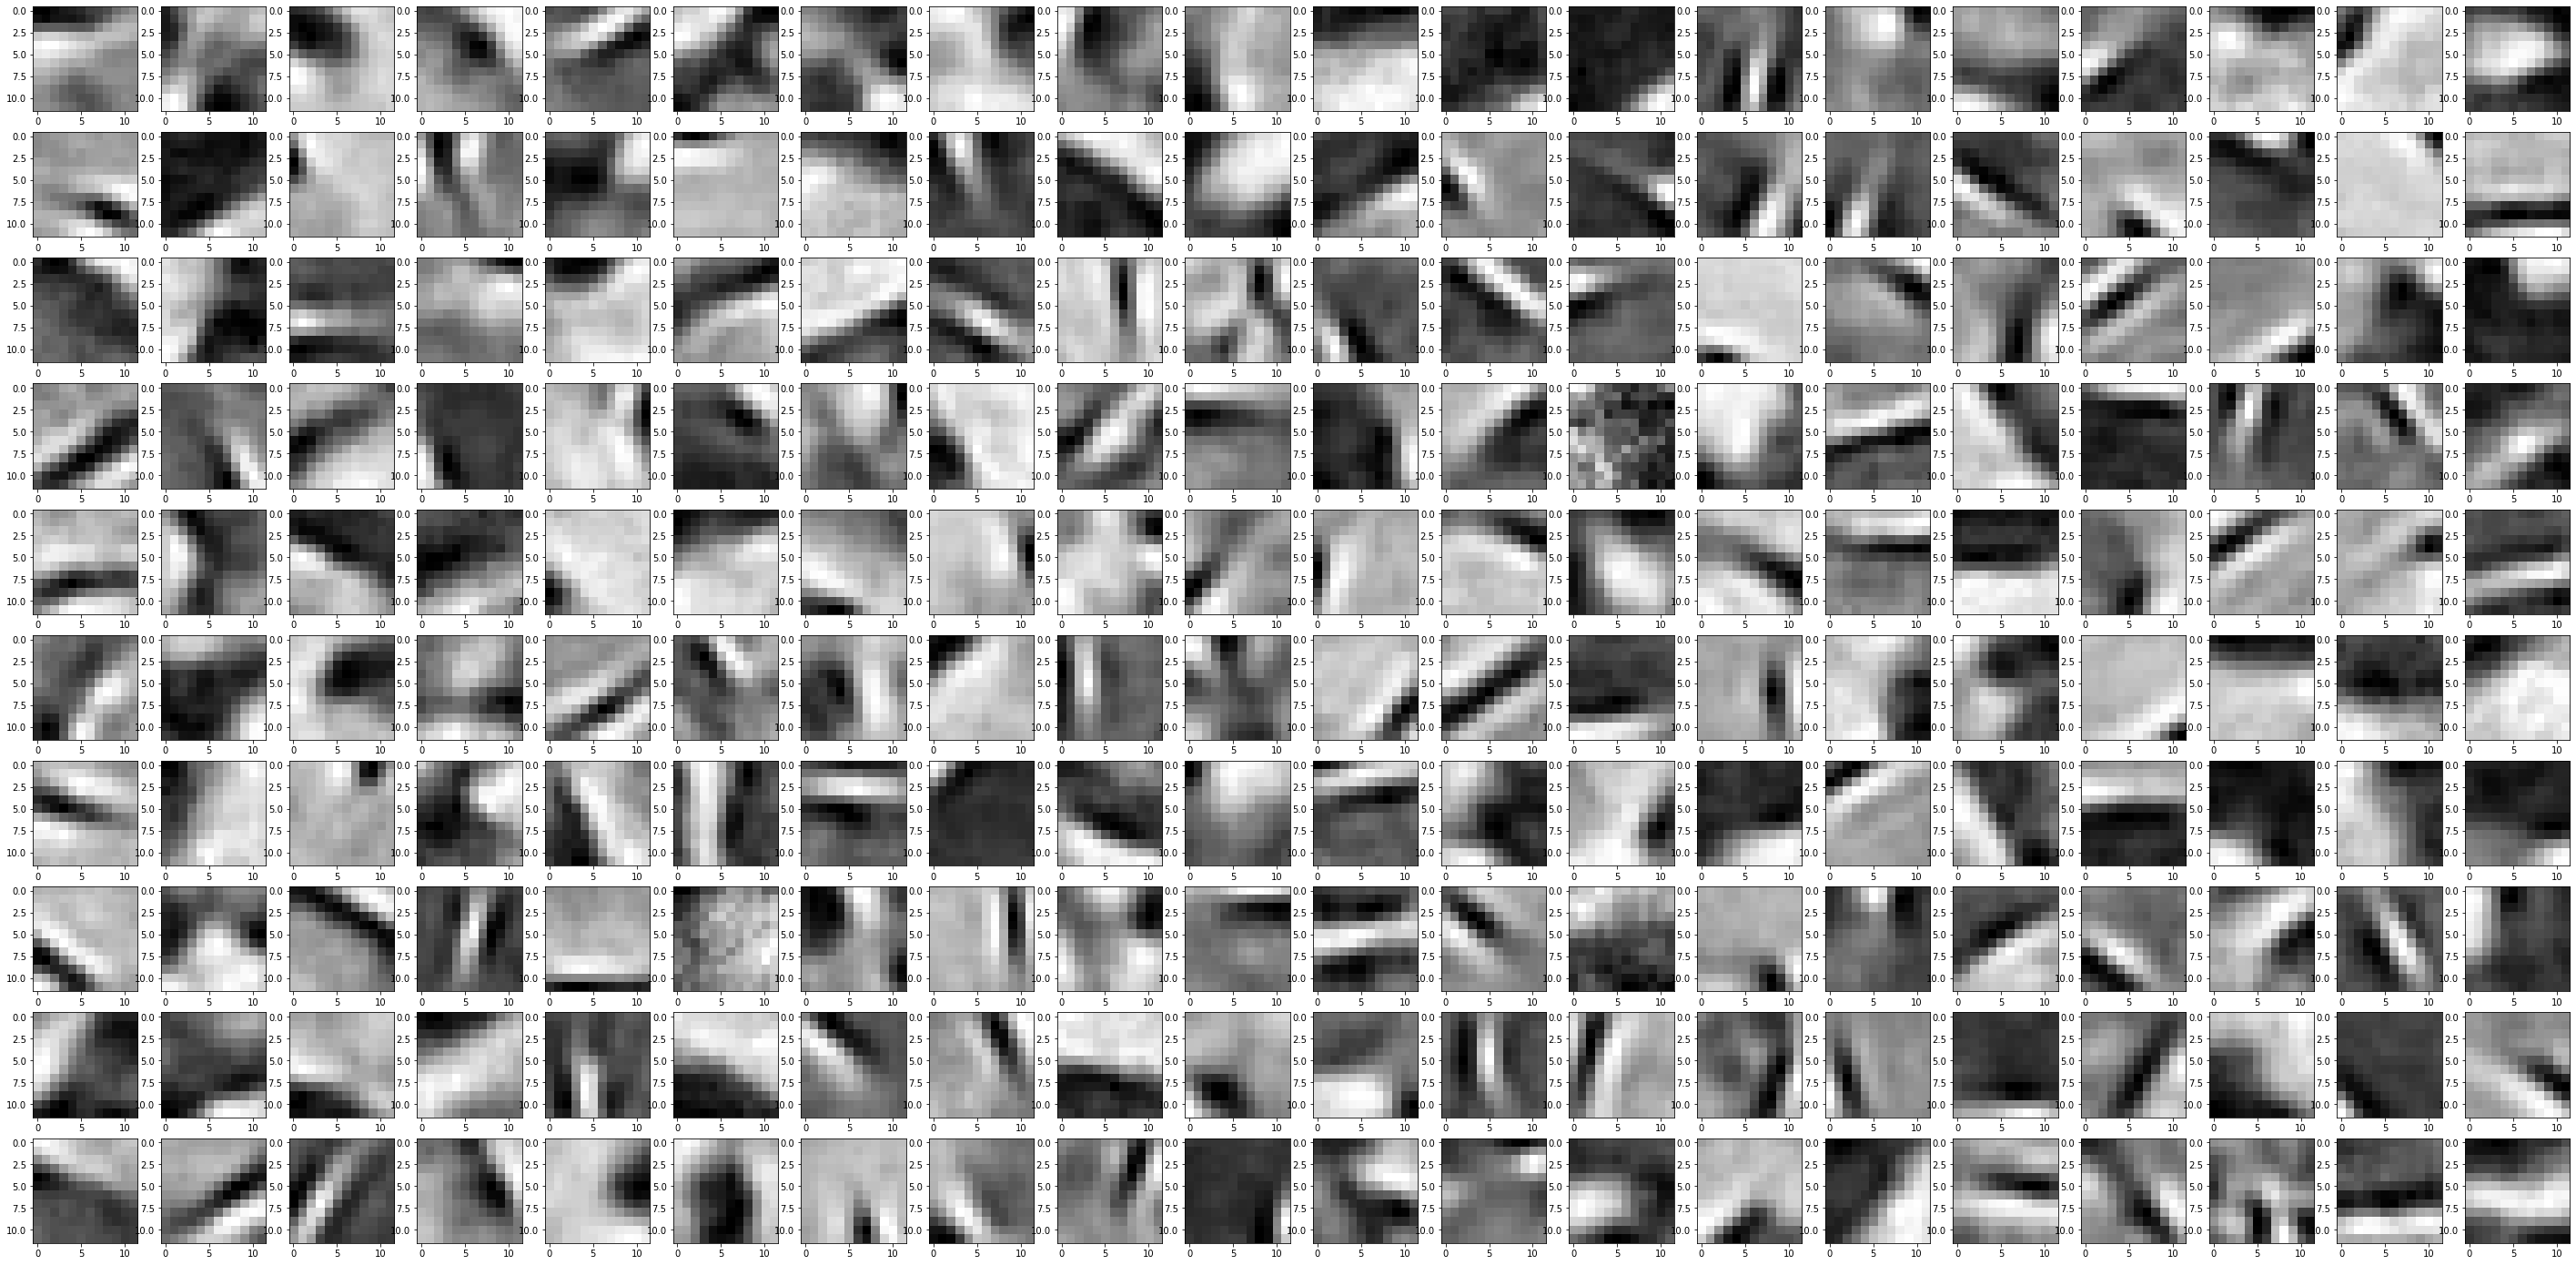

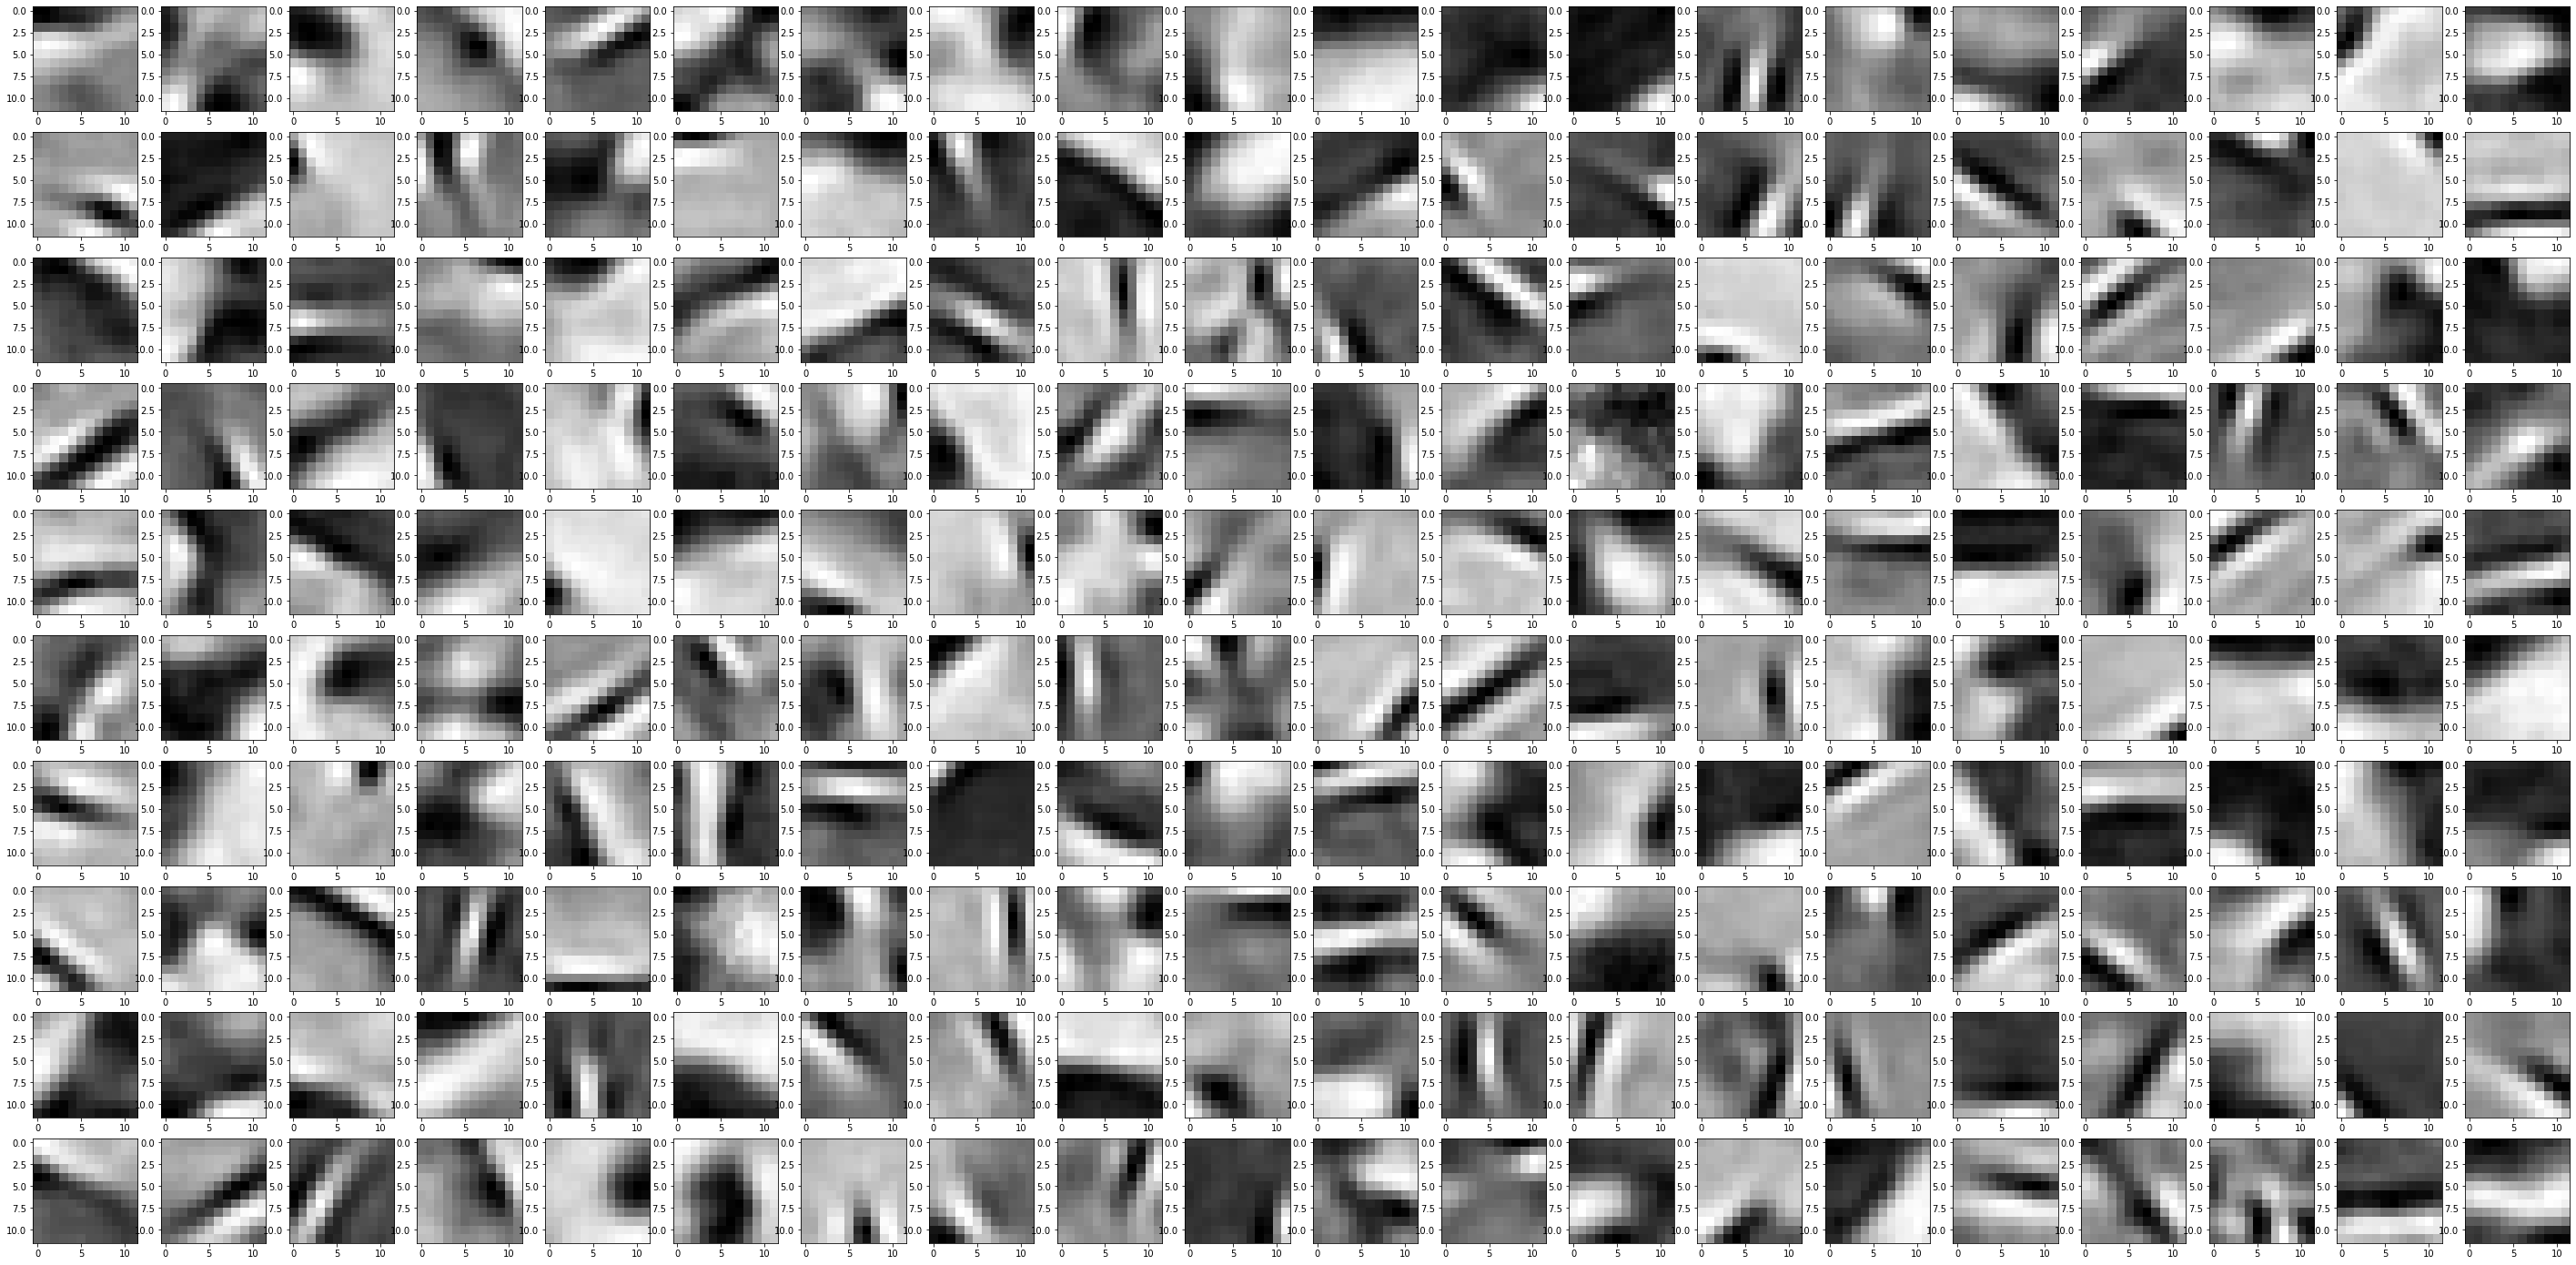

In [35]:
step_size = 0.1

frob_list = []
frob = 1e99
i = 0
while(frob > 1e-3):
    #generate batch of size 25
    batch_size = 25
    x = np.zeros([width, width, batch_size])
    #generate random 5 numbers btw 0-9 to select images
    rand_idx = random.sample(range(10), 5)
    n_patches_per_img(5, rand_idx, x)
    #reshapes into dxn array, features are columns
    x_new = np.reshape(x, (144, 25))

    #step 1: find coefficients using LASSO
    lasso = linear_model.Lasso(
        alpha=0.01, fit_intercept = False, max_iter=5000)
    lasso.fit(v_norm, x_new)
    a_cur = lasso.coef_ #note this is transpose of what we want
    
    #step 2: compute gradient
    va_cur = np.matmul(v_norm, np.transpose(a_cur))
    grad = -2*np.matmul(x_new - va_cur, a_cur)
    
    #compute new codebook, normalize
    v_new = v_norm - step_size*grad
    v_new_norm = preprocessing.normalize(v_new, axis=0) 
    #compute new Frobeus norm of diff. btw codebook
    diff = v_new_norm - v_norm
    frob = np.linalg.norm(diff)
    v_norm = v_new_norm
    i = i + 1
    step_size = step_size*0.999
    if i % 100 == 0:
        frob_list.append(frob)
    #at every 2000 iterations, show codebook
    if i % 2000 == 0:
        print_codebook(v_norm.reshape(12, 12, 200))

# Show final codebook

Below, we have printed the final codebook. We can see that the 12x12 images are similar in representation to those found in the study by Olshausen and Field, 1996. Orientation preference seems to be denoted similarly to that in the paper, by the orientation of a line in the corresponding image in the codebook.

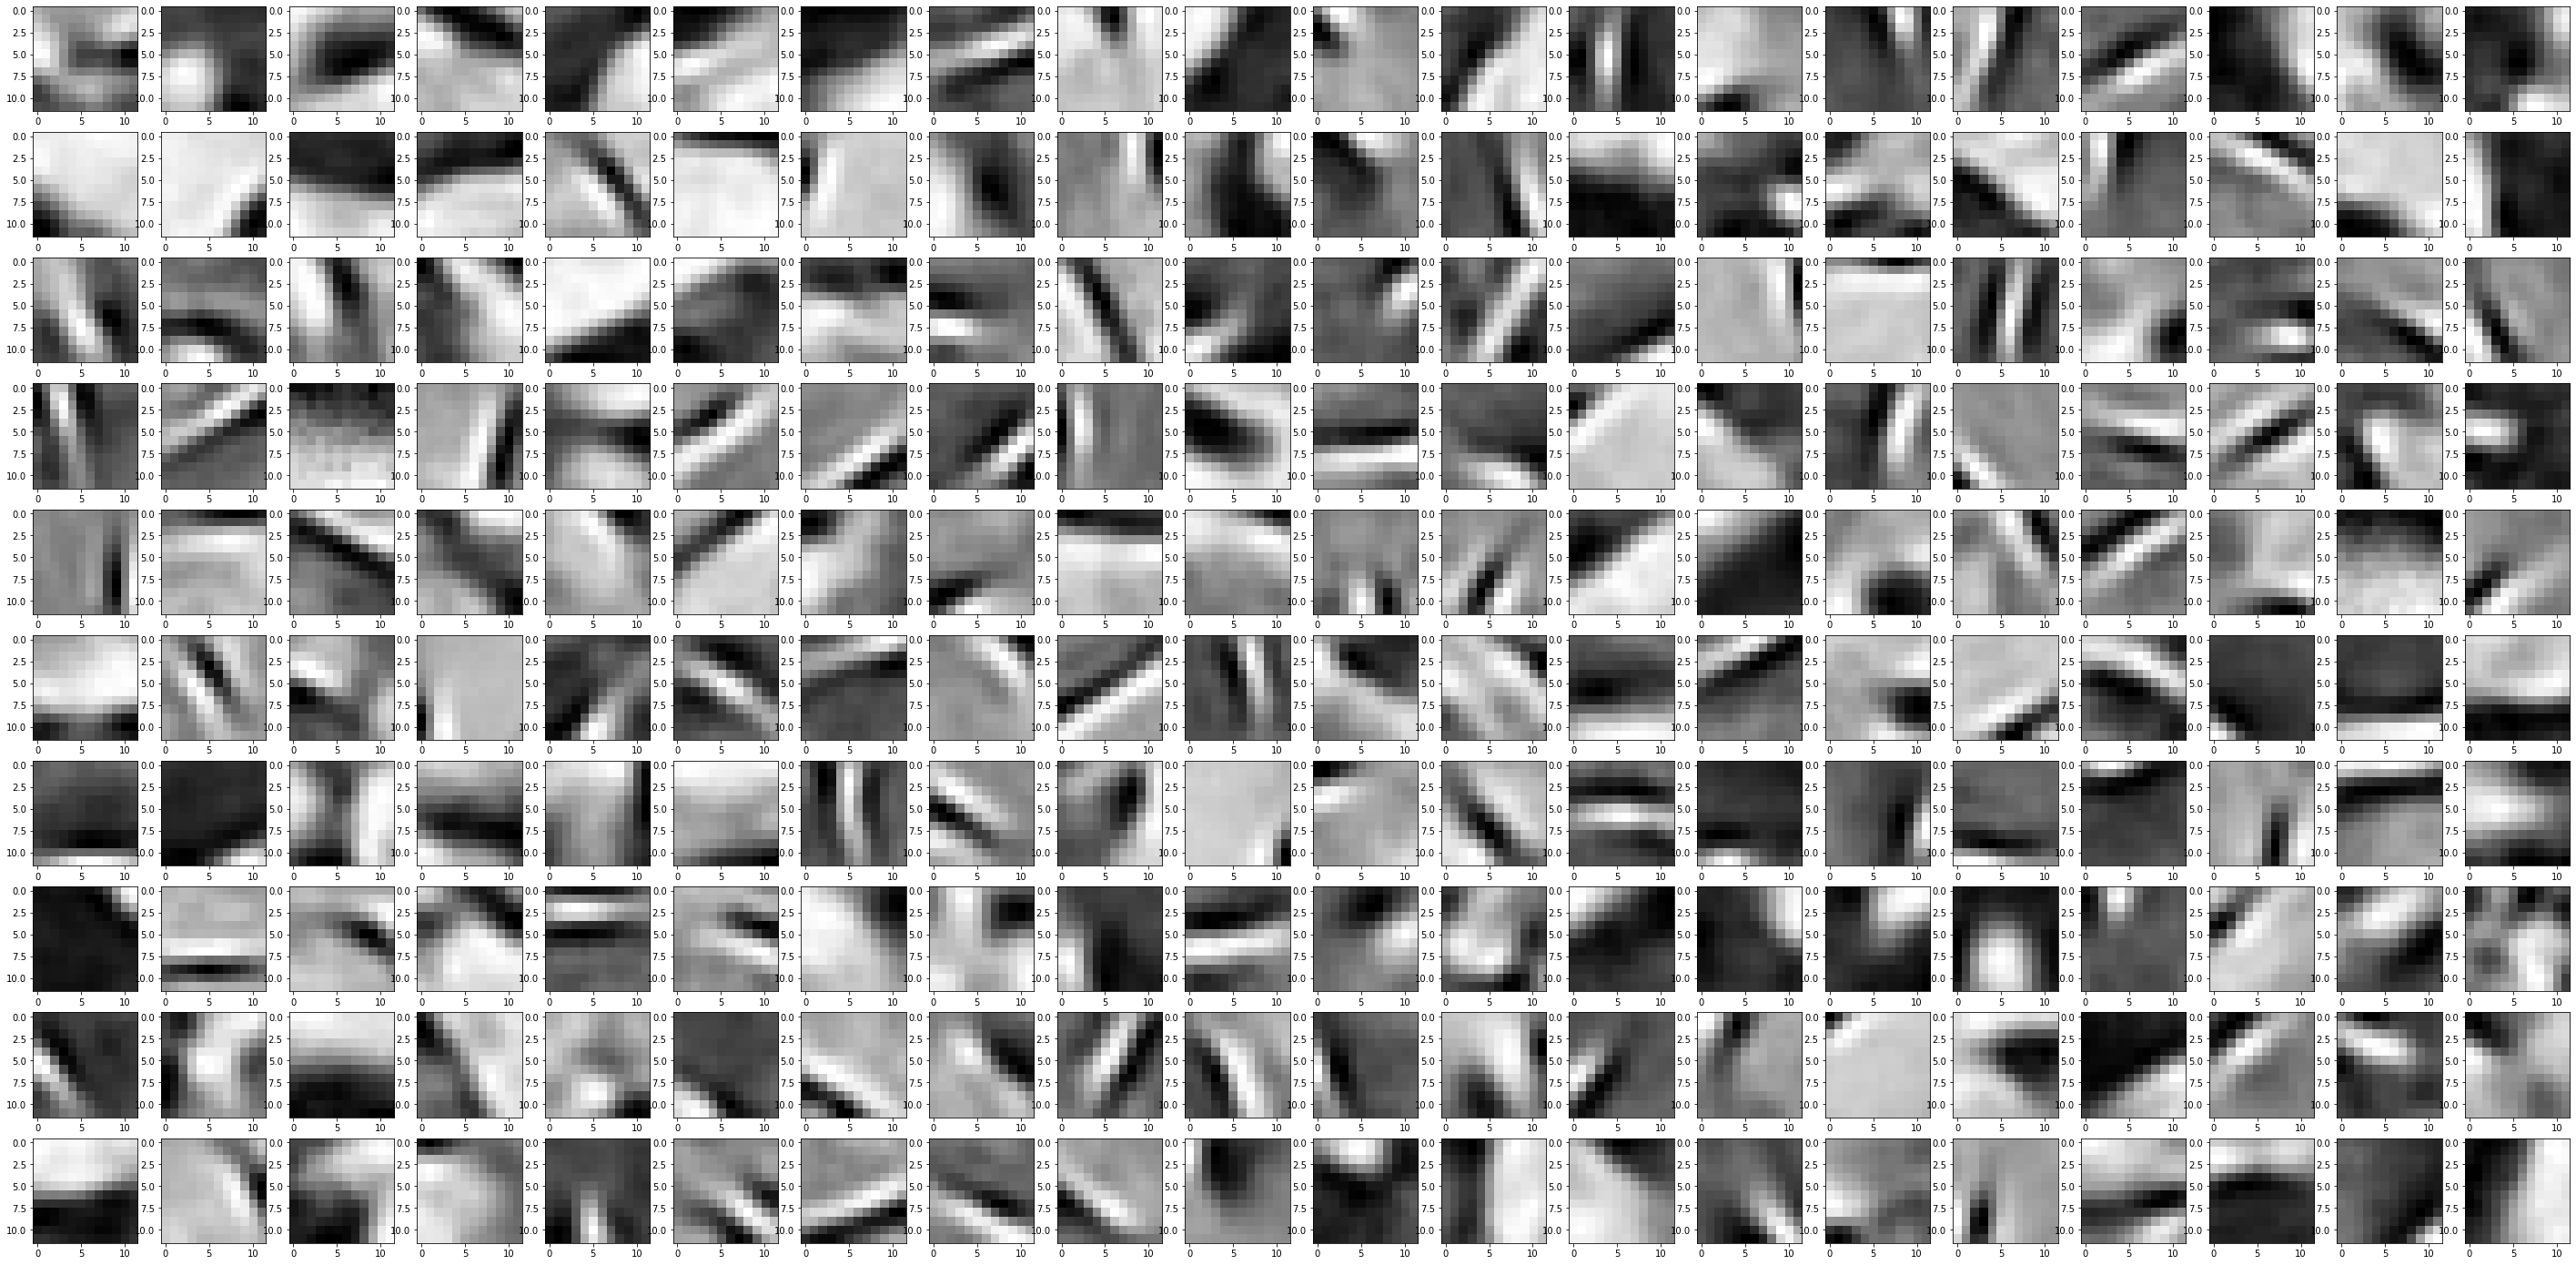

In [33]:
print_codebook(v_norm.reshape(12, 12, 200))

# Monitor convergence of SGD

Using a learning rate of 0.1, and decreasing the rate by a factor of 0.1% each iteration, we obtain the following graph of the Frobeus norm fo the difference in codebooks vs. the timestep, plotted for every 100 iterations. In the paper, convergence was observed after ~4000 updates. Here, the tolerance is set at $||V_{cur} - V_{new}||^2_{Frob} \leq 0.001$, so it takes ~9000 timesteps to converge. In the paper, the tolerance is $1%$, or $0.01$. We can see that around the $4000^{th}$ iteration, the value of the Frobenius norm is already close to 0. 

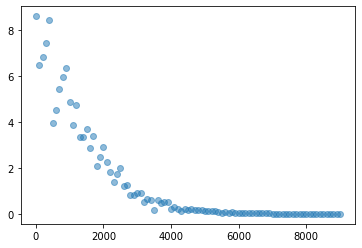

In [34]:
indices = np.array(range(len(frob_list))) * 100
plt.scatter(indices, frob_list, alpha=0.5)
plt.show()

# Show reconstructions of patch images

Below, we reconstruct patches using the sparse representation obtained from above. We sample 2 patches each of the 10 images, with the original image shown above and the reconstructed image shown below.

In [39]:
#take P = 20 new patches from the image
p = np.zeros([width, width, 20])
n_patches_per_img(2, list(range(10)), p)
p_new = np.reshape(p, (144, 20))

#compute the alphas for each image
lasso = linear_model.Lasso(
    alpha=0.01, fit_intercept = False, max_iter=5000)
lasso.fit(v_norm, p_new)
a_cur = lasso.coef_ #note this is transpose of what we want
    
#compute the sparse representation
p_sparse = np.matmul(v_norm, np.transpose(a_cur))

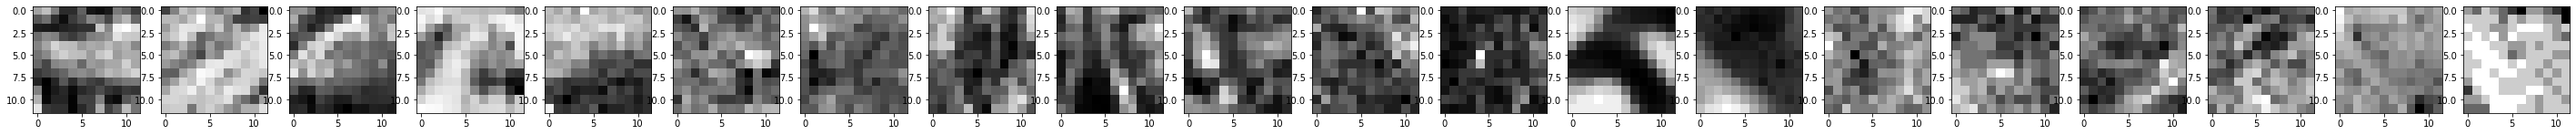

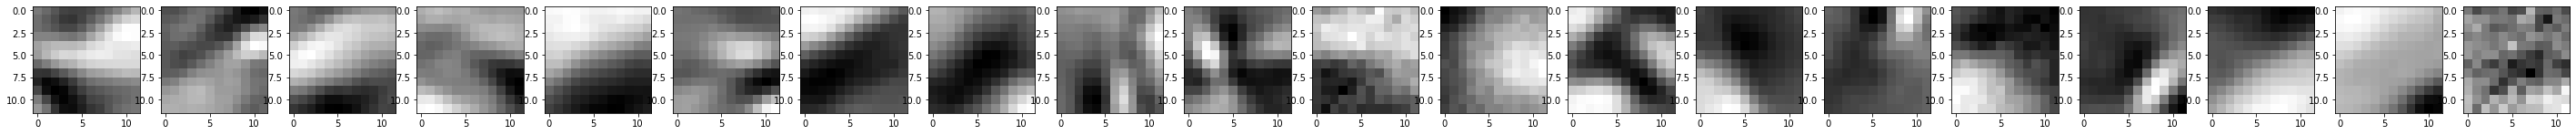

In [47]:
fig1 = plt.figure(figsize=(50, 2.5))
fig2 = plt.figure(figsize=(50, 2.5))
for i in range(20):
    sub1 = fig1.add_subplot(1, 20, i + 1)
    sub1.imshow(p_new.reshape(12, 12, 20)[:,:,i], cmap='gray')
for i in range(20):
    sub2 = fig2.add_subplot(1, 20, i + 1)
    sub2.imshow(p_sparse.reshape(12, 12, 20)[:,:,i], cmap='gray')